In [1]:
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import pickle
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [2]:
# 可用 GPU 数量
n_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {n_gpus}")

# 每块 GPU 的名称
for i in range(n_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 当前 GPU 内存使用情况
for i in range(n_gpus):
    print(f"GPU {i} Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")
    print(f"GPU {i} Memory Cached: {torch.cuda.memory_reserved(i)/1024**3:.2f} GB")


Number of GPUs available: 1
GPU 0: NVIDIA A30
GPU 0 Memory Allocated: 0.00 GB
GPU 0 Memory Cached: 0.00 GB


Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/0.1GeV.root
threshold: 0.02282


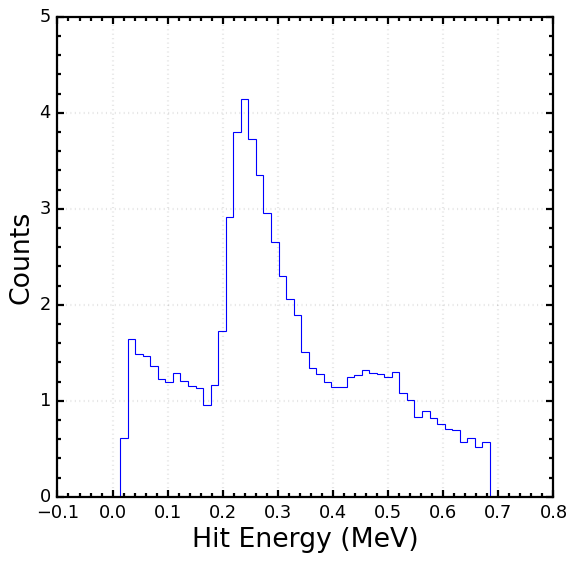

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/10.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.

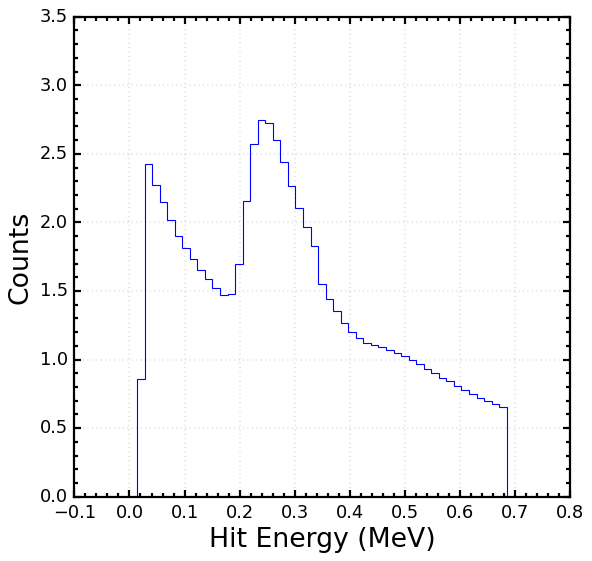

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_55.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_28.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_65.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_91.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_66.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Uniform/0_70GeV_67.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu20

In [3]:
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=5  # mm
SamplingLayer=60
ECAL_layers=120
Threshold=Threshold_i*MIP_table[Si]
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    NRootFiles=0
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        NRootFiles+=1
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name,draw_hist=(NRootFiles==1))
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file, draw_hist=(input_file == root_files[0]))
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name,draw_hist=False):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    if draw_hist:
        print("threshold:", Threshold)
        plt.hist(ak.to_numpy(ak.flatten(energy))*1000,
            bins=50, range=(0, 3*MIP_table[Si]), histtype='step', density=True)
        plt.xlabel('Hit Energy (MeV)')
        plt.ylabel('Counts')
        plt.show()
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=SamplingLayer)
        N_layers_event = np.bincount(layers, minlength=SamplingLayer)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

length after zero suppression: 1249834 1249834 1249834 1249834 1249834
length after zero suppression: 59993 59993 59993 59993 59993


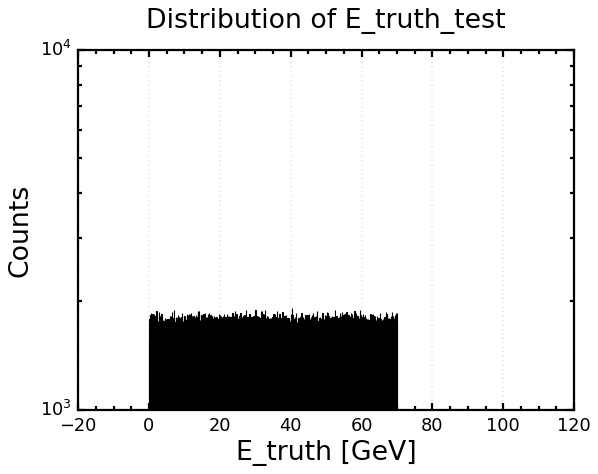

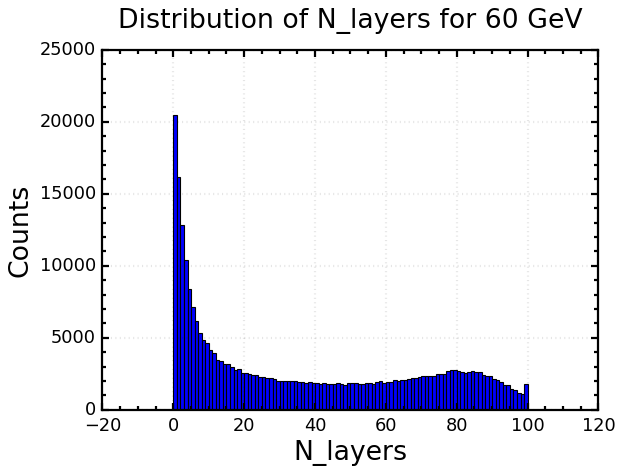

In [4]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
#Draw N_layers for 60 GeV
N_layers_60GeV = N_layers_test[abs(E_truth_test - 60.0) < 0.1]
N_layers_60GeV_flat = ak.flatten(N_layers_60GeV)
plt.figure(figsize=fig_size)
plt.hist(N_layers_60GeV_flat, bins=100, range=(0, 100), edgecolor="black")
plt.xlabel("N_layers")
plt.ylabel("Counts")
plt.title("Distribution of N_layers for 60 GeV")
plt.grid(True)
plt.show()


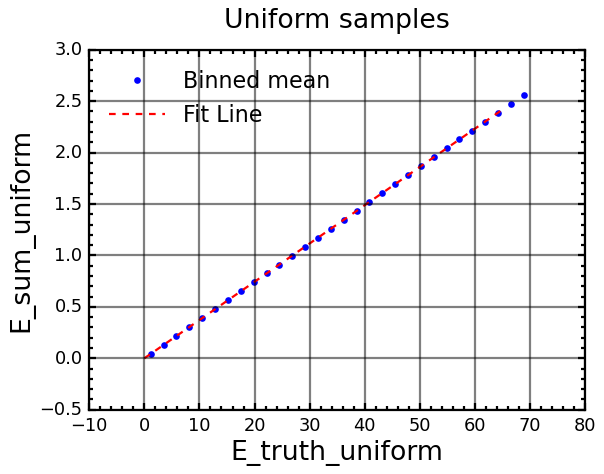

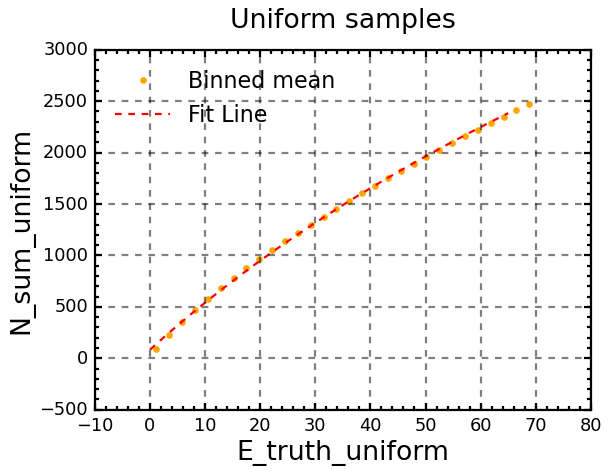

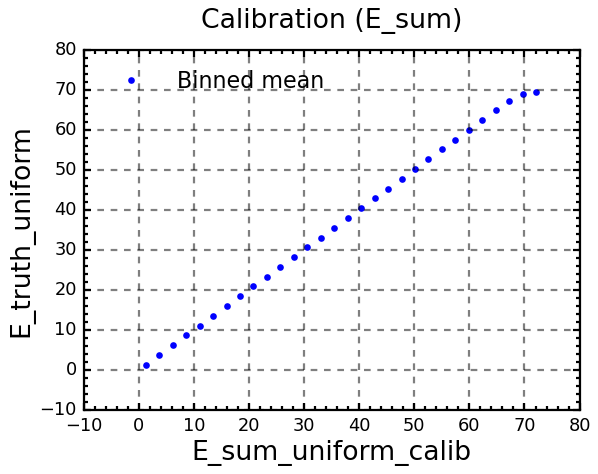

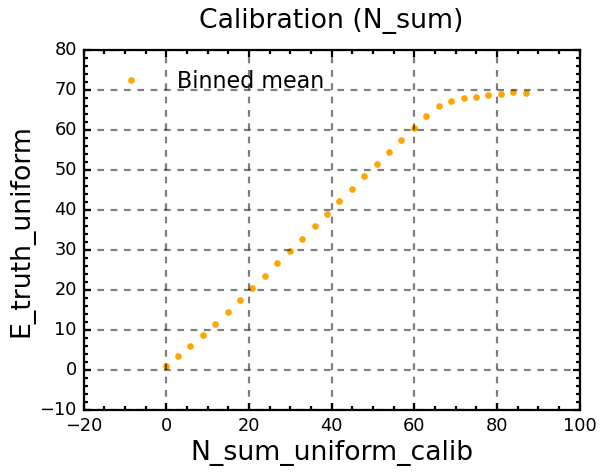

In [5]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [6]:
from sklearn import base


class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        # base = torch.where(abs_rel < self.delta,
        #            0.5 * rel**2,
        #            self.delta * (abs_rel - 0.5*self.delta))
        # loss = base * (1 + abs_rel)
        return torch.mean(loss)

class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(x)
        #out = x
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        print(f"Input dim: {input_dim}")
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X_train,y_train,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    val_split = 0.2
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32)
    y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_validate_tensor, y_validate_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    model.eval()
    y_validate_pred_list = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)      
            pred = model(xb)
            y_validate_pred_list.append(pred.detach().cpu().numpy())
    y_validate_pred = np.concatenate(y_validate_pred_list, axis=0)

    return model,scaler,y_validate, y_validate_pred, best_val_loss

In [7]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [8]:
X_train = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    N_layers_uniform_ratio,
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
    LayerNum_uniform[:, np.newaxis],
    Average_E_layer_uniform[:, np.newaxis],
    Average_N_layer_uniform[:, np.newaxis],
])
X_test = np.hstack(
    [E_layers_test, 
    E_layers_test_ratio,
    E_sum_test_calib[:,np.newaxis], 
    N_layers_test, 
    N_layers_test_ratio,
    N_sum_test_calib[:,np.newaxis],
    E_N_layers_test,
    LayerNum_test[:, np.newaxis],
    Average_E_layer_test[:, np.newaxis],
    Average_N_layer_test[:, np.newaxis],
])
y_train = E_truth_uniform
y_test = E_truth_test

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

Using device: cuda
Random state: 42
Training samples: 999867, Validation samples: 249967
learning rate: 0.0005, batch size: 4096, epochs: 100, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Input dim: 305
Epoch 001/100 | Train Loss: 0.034925 | Val Loss: 0.008847| LR: 0.000200
Epoch 002/100 | Train Loss: 0.006684 | Val Loss: 0.004040| LR: 0.000300
Epoch 003/100 | Train Loss: 0.004565 | Val Loss: 0.003156| LR: 0.000400
Epoch 004/100 | Train Loss: 0.003455 | Val Loss: 0.002287| LR: 0.000500
Epoch 005/100 | Train Loss: 0.002845 | Val Loss: 0.002209| LR: 0.000500
Epoch 006/100 | Train Loss: 0.002485 | Val Loss: 0.001425| LR: 0.000499
Epoch 007/100 | Train Loss: 0.002325 | Val Loss: 0.001261| LR: 0.000498
Epoch 008/100 | Train Loss: 0.001956 | Val Loss: 0.002265| LR: 0.000495
Epoch 009/100 | Train Loss: 0.001875 | Val Loss: 0.000935| LR: 0.000491
Epoch 010/100 | Train Loss: 0.001658 | Val Loss: 0.000840| LR: 0.00

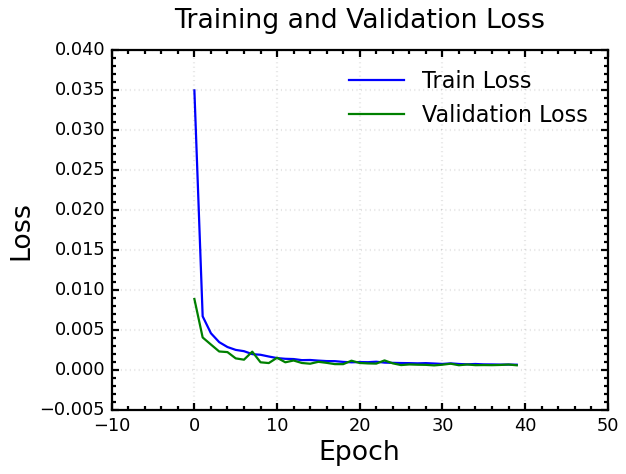

In [14]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
MLP_Config="WD1e-7"
for lr in ParameterScan:
  mlp_model,scaler,y_validate, y_validate_pred, best_val_loss = train_mlp(X_train, y_train,
                    activation=nn.PReLU(),
                    hidden_dims=[256, 128, 64],
                      dropout=0.1,
                    loss=HuberRelativeLoss(delta=0.05),
                    lr=5e-4,
                    weight_decay=1e-7,
                    batch_size=4096,
                    epochs=100,
                      patience=10,
                      random_state=42)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")

Step 1 Linear fit coeffs: [-8.87536381e-05  2.62531534e-03]


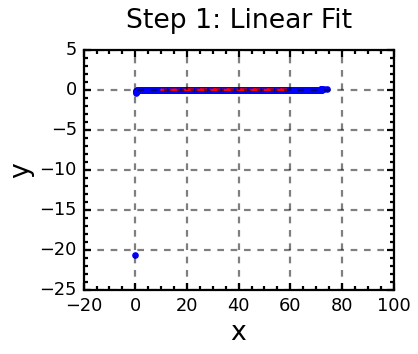

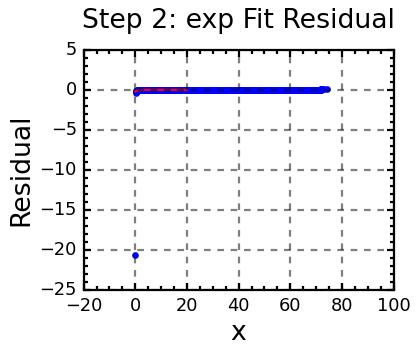

Step 3 Linear fit coeffs: [-8.87652112e-05  9.92712068e-03]


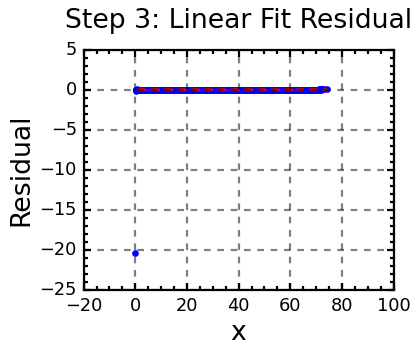

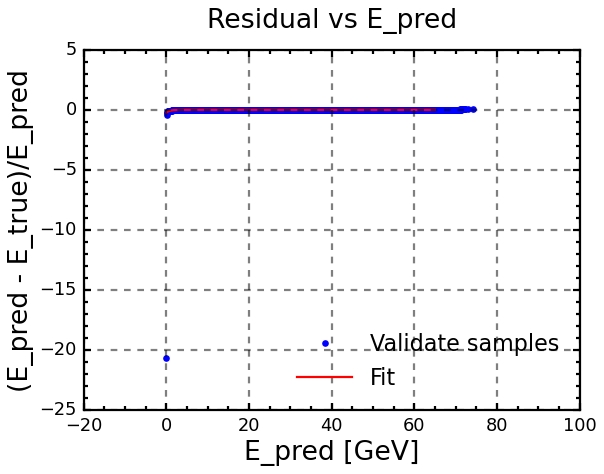

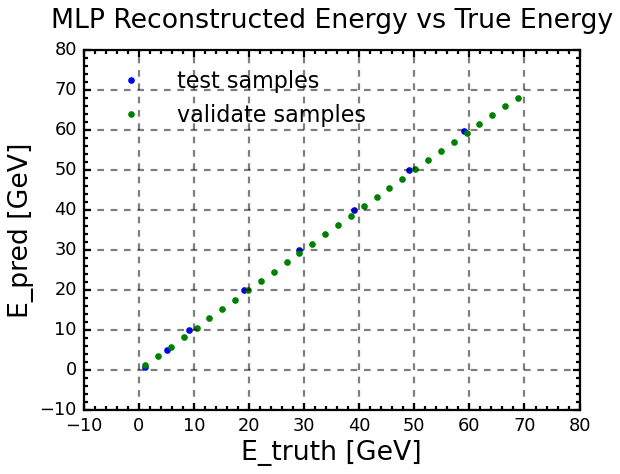

In [15]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (0.1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > linear_range[0]) & (x < linear_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "Energy": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

y_pred=y_validate_pred
y_true=y_validate
X_test_scaled = scaler.transform(X_test)
mlp_model.eval()
y_pred_test_mlp_list = []
batch_size_pred = 4096
with torch.no_grad():
    for i in range(0, len(X_test_scaled), batch_size_pred):
        batch = torch.tensor(X_test_scaled[i:i+batch_size_pred], dtype=torch.float32).to(device)
        preds = mlp_model(batch)
        y_pred_test_mlp_list.append(preds.detach().cpu().numpy())
        del batch, preds
        torch.cuda.empty_cache()
y_pred_test_mlp = np.concatenate(y_pred_test_mlp_list, axis=0)

Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=30)
Reco_hist_mlp_all.append(Reco_hist_mlp)

Nbins=1000
fit_range = (0, 65) 
mask = y_pred>0
residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=Nbins)
x_fit = np.linspace(fit_range[0], fit_range[1], Nbins)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred[mask], residual_E, num_bins=Nbins, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [16]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


In [17]:
# #This cell is left here for debug
# print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
# Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
# print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
# i_E = 6 # Example index, change as needed
# #print(len(Reco_hist_mlp))
# #print(Reco_hist_mlp[i_E])
# mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
#     "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.09209447788289804, Peak: 0.09785643369933544, RMS: 0.0493655604130402
Initial Gamma Fit Parameters: [np.float64(132.2444069119901), np.float64(11.984222922138136), np.float64(-0.49951340278325324), np.float64(0.0493655604130402)]
Gamma Fit Bounds: lower [np.float64(1.322444069119901), np.float64(0.1984222922138137), np.float64(-1.0499513402783254), np.float64(0.004936556041304021)], 
 upper [np.float64(793.4664414719406), np.float64(119.84222922138136), np.float64(9.25072989582512), np.float64(0.493655604130402)]
Gamma Fit Parameters: [ 1.29976984e+02  5.87972933e+01 -1.97243830e-01  4.93655604e-03]
Gamma Fit Peak: 0.08807574766363757 ± 0.0007154215073954553, Mean: 0.09301230370494268 ± 0.0007206670262485569, Resolution: 0.4297801966256353 ± 0.007007339212036943


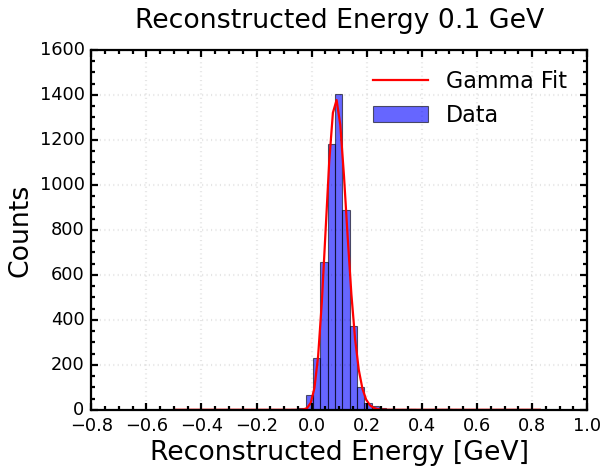

appending results for E = 0.1
Mean_Gamma: 0.09301230370494268 Mean_Gamma_Error: 0.0007206670262485569
Peak_Gamma: 0.08807574766363757 Peak_Gamma_Error: 0.0007154215073954553
Mean: 0.25440687898986447, Peak: 0.24252272709606948, RMS: 0.05985814500185768
Initial Gamma Fit Parameters: [np.float64(91.39173346331214), np.float64(6.780915593919069), np.float64(-0.15148614987630105), np.float64(0.05985814500185768)]
Gamma Fit Bounds: lower [np.float64(0.9139173346331214), np.float64(-0.3219084406080931), np.float64(-1.01514861498763), np.float64(0.0059858145001857686)], 
 upper [np.float64(548.3504007798729), np.float64(67.80915593919069), np.float64(9.772770775185549), np.float64(0.5985814500185769)]
Gamma Fit Parameters: [ 9.09063637e+01  6.78091559e+01 -2.08107172e-01  6.85454775e-03]
Gamma Fit Peak: 0.24983937707836562 ± 0.0008596221499207388, Mean: 0.25669392482357895 ± 0.0008650412406715368, Resolution: 0.22592385331882298 ± 0.0025456793720784582


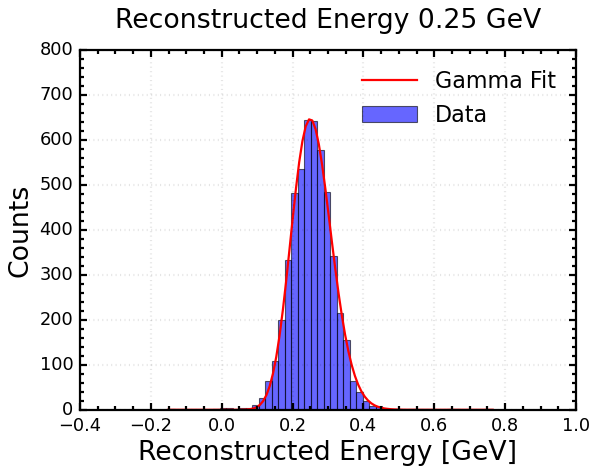

appending results for E = 0.25
Mean_Gamma: 0.25669392482357895 Mean_Gamma_Error: 0.0008650412406715368
Peak_Gamma: 0.24983937707836562 Peak_Gamma_Error: 0.0008596221499207388
Mean: 0.5157609356197081, Peak: 0.5041666621556928, RMS: 0.0745021693465907
Initial Gamma Fit Parameters: [np.float64(68.5256512417113), np.float64(4.6715802342049475), np.float64(0.16771807389478535), np.float64(0.0745021693465907)]
Gamma Fit Bounds: lower [np.float64(0.685256512417113), np.float64(-0.5328419765795052), np.float64(-0.9832281926105214), np.float64(0.00745021693465907)], 
 upper [np.float64(411.1539074502678), np.float64(46.71580234204947), np.float64(10.251577110842177), np.float64(0.745021693465907)]
Gamma Fit Parameters: [6.79073150e+01 2.03893153e+01 1.90911302e-01 1.60000025e-02]
Gamma Fit Peak: 0.5011403950982737 ± 0.0012884444415642692, Mean: 0.5171403975792103 ± 0.0013149659673394117, Resolution: 0.14416570504528362 ± 0.0020332401622729698


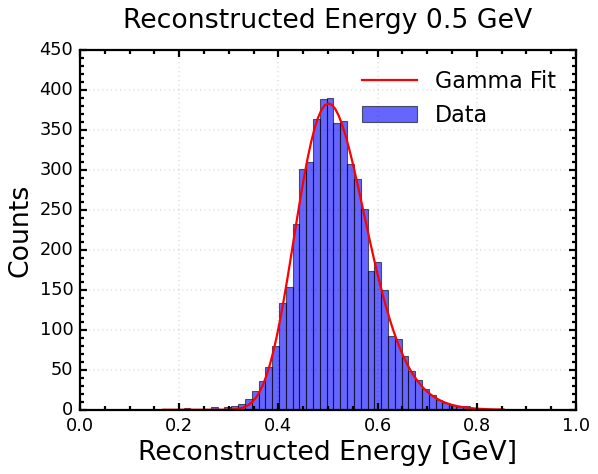

appending results for E = 0.5
Mean_Gamma: 0.5171403975792103 Mean_Gamma_Error: 0.0013149659673394117
Peak_Gamma: 0.5011403950982737 Peak_Gamma_Error: 0.0012884444415642692
Mean: 1.0213880542476128, Peak: 1.0301390353163966, RMS: 0.10463967684783354
Initial Gamma Fit Parameters: [np.float64(114.17539701407088), np.float64(6.145773282391826), np.float64(0.37829632399808294), np.float64(0.10463967684783354)]
Gamma Fit Bounds: lower [np.float64(1.141753970140709), np.float64(-0.38542267176081735), np.float64(-0.9621703676001917), np.float64(0.010463967684783354)], 
 upper [np.float64(685.0523820844253), np.float64(61.457732823918256), np.float64(10.567444485997125), np.float64(1.0463967684783353)]
Gamma Fit Parameters: [1.13944707e+02 6.14577328e+01 2.18616346e-01 1.30889641e-02]
Gamma Fit Peak: 1.0099454374331411 ± 0.0015049549664221667, Mean: 1.0230344014932373 ± 0.0015151713746885775, Resolution: 0.1016004499234173 ± 0.001035073291876717


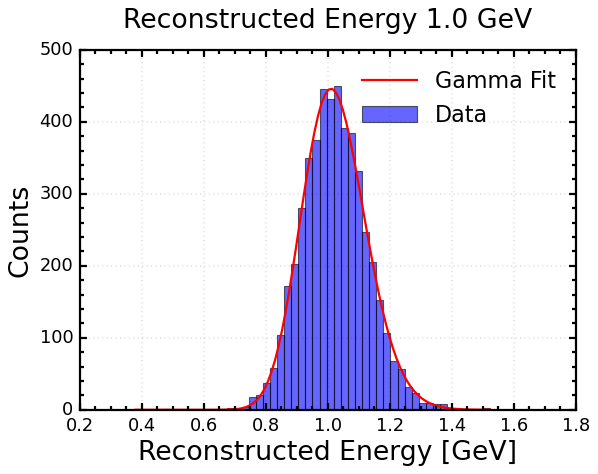

appending results for E = 1.0
Mean_Gamma: 1.0230344014932373 Mean_Gamma_Error: 0.0015151713746885775
Peak_Gamma: 1.0099454374331411 Peak_Gamma_Error: 0.0015049549664221667
Mean: 1.987364672839633, Peak: 1.973662767551061, RMS: 0.15234491997325586
Initial Gamma Fit Parameters: [np.float64(132.65437323743333), np.float64(4.18902461045995), np.float64(1.3491880537931127), np.float64(0.15234491997325586)]
Gamma Fit Bounds: lower [np.float64(1.3265437323743334), np.float64(-0.581097538954005), np.float64(-0.8650811946206887), np.float64(0.015234491997325586)], 
 upper [np.float64(795.9262394246), np.float64(41.8902461045995), np.float64(12.023782080689669), np.float64(1.5234491997325585)]
Gamma Fit Parameters: [1.32155264e+02 4.18902461e+01 1.01910885e+00 2.32778300e-02]
Gamma Fit Peak: 1.970945049898 ± 0.0026012962502331275, Mean: 1.9942228799342554 ± 0.002626850185676551, Resolution: 0.07644066076064068 ± 0.0009309922160113662


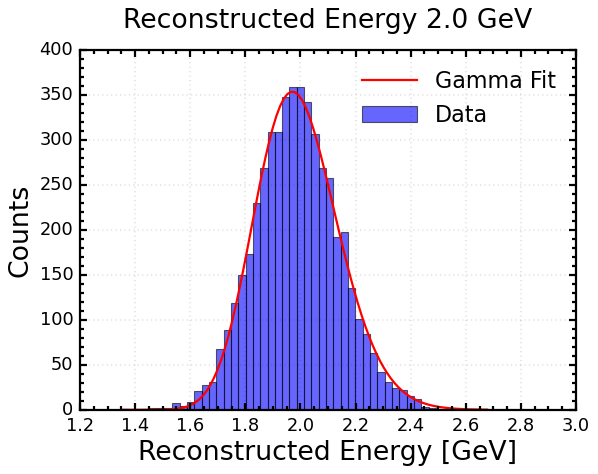

appending results for E = 2.0
Mean_Gamma: 1.9942228799342554 Mean_Gamma_Error: 0.002626850185676551
Peak_Gamma: 1.970945049898 Peak_Gamma_Error: 0.0026012962502331275
Mean: 4.9214887570643215, Peak: 4.8688023416791015, RMS: 0.2649943344008363
Initial Gamma Fit Parameters: [np.float64(242.33090500743225), np.float64(4.3205567739750474), np.float64(3.776565690503779), np.float64(0.2649943344008363)]
Gamma Fit Bounds: lower [np.float64(2.4233090500743226), np.float64(-0.5679443226024952), np.float64(-0.6223434309496221), np.float64(0.026499433440083632)], 
 upper [np.float64(1453.9854300445936), np.float64(43.20556773975048), np.float64(15.664848535755668), np.float64(2.649943344008363)]
Gamma Fit Parameters: [2.40770679e+02 4.32055677e+01 3.23355707e+00 3.93031423e-02]
Gamma Fit Peak: 4.892368504952829 ± 0.004949394594862, Mean: 4.931671647220369 ± 0.004996386261230381, Resolution: 0.05280535539125451 ± 0.0007044765085831313


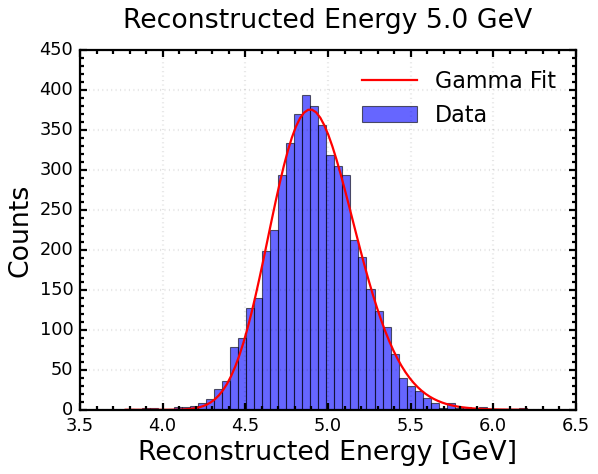

appending results for E = 5.0
Mean_Gamma: 4.931671647220369 Mean_Gamma_Error: 0.004996386261230381
Peak_Gamma: 4.892368504952829 Peak_Gamma_Error: 0.004949394594862
Mean: 9.968716068655327, Peak: 9.847541119653181, RMS: 0.4109360726056375
Initial Gamma Fit Parameters: [np.float64(444.30830648430555), np.float64(5.379614588484138), np.float64(7.758038377531663), np.float64(0.4109360726056375)]
Gamma Fit Bounds: lower [np.float64(4.443083064843056), np.float64(-0.46203854115158616), np.float64(-0.2241961622468337), np.float64(0.041093607260563755)], 
 upper [np.float64(2665.849838905833), np.float64(53.79614588484138), np.float64(21.637057566297493), np.float64(4.109360726056376)]
Gamma Fit Parameters: [4.40342234e+02 5.37961459e+01 7.12301939e+00 5.31374345e-02]
Gamma Fit Peak: 9.928471133033291 ± 0.007879031597819497, Mean: 9.981608567489848 ± 0.007938837069349143, Resolution: 0.039254891938789296 ± 0.0005412864963309787


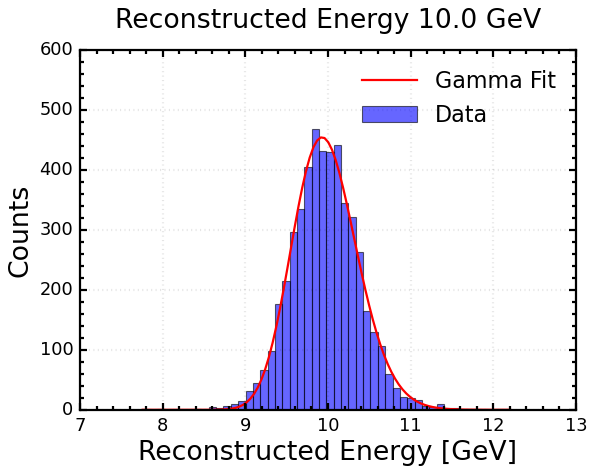

appending results for E = 10.0
Mean_Gamma: 9.981608567489848 Mean_Gamma_Error: 0.007938837069349143
Peak_Gamma: 9.928471133033291 Peak_Gamma_Error: 0.007879031597819497
Mean: 20.055137598948754, Peak: 19.96067042276375, RMS: 0.5777669431454283
Initial Gamma Fit Parameters: [np.float64(481.9914613762214), np.float64(4.588471585214869), np.float64(17.4040703974495), np.float64(0.5777669431454283)]
Gamma Fit Bounds: lower [np.float64(4.819914613762214), np.float64(-0.5411528414785132), np.float64(0.7404070397449503), np.float64(0.05777669431454283)], 
 upper [np.float64(2891.9487682573285), np.float64(45.88471585214869), np.float64(36.10610559617425), np.float64(5.777669431454283)]
Gamma Fit Parameters: [4.78681928e+02 4.58847159e+01 1.62469303e+01 8.38057848e-02]
Gamma Fit Peak: 20.008529185311534 ± 0.014111568342605284, Mean: 20.09233497008986 ± 0.014240860149035474, Resolution: 0.02837218973666325 ± 0.00048425782481871234


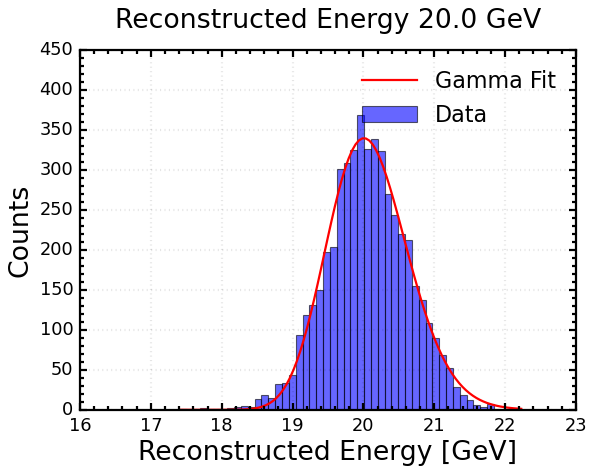

appending results for E = 20.0
Mean_Gamma: 20.09233497008986 Mean_Gamma_Error: 0.014240860149035474
Peak_Gamma: 20.008529185311534 Peak_Gamma_Error: 0.014111568342605284
Mean: 30.050804216197086, Peak: 30.026193879644453, RMS: 0.7218773272537434
Initial Gamma Fit Parameters: [np.float64(584.9346389401871), np.float64(4.654630137706538), np.float64(26.690732253034767), np.float64(0.7218773272537434)]
Gamma Fit Bounds: lower [np.float64(5.849346389401871), np.float64(-0.5345369862293462), np.float64(1.6690732253034768), np.float64(0.07218773272537435)], 
 upper [np.float64(3509.607833641123), np.float64(46.546301377065376), np.float64(50.03609837955215), np.float64(7.218773272537434)]
Gamma Fit Parameters: [5.78799850e+02 4.65463014e+01 2.53327135e+01 1.02336417e-01]
Gamma Fit Peak: 29.99375876116094 ± 0.016741670694377375, Mean: 30.09609517824358 ± 0.016900958679767476, Resolution: 0.0232777983770893 ± 0.00038222332228416095


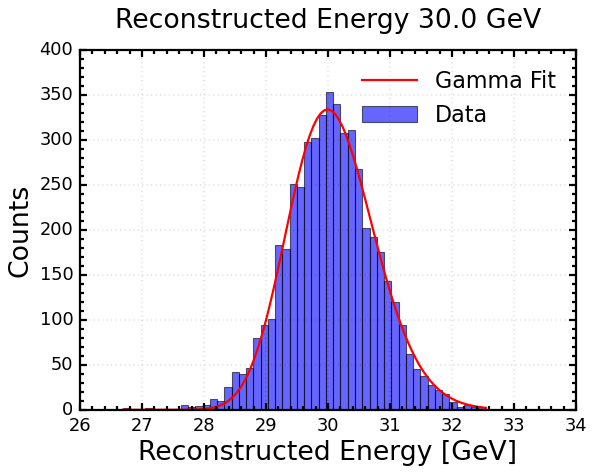

appending results for E = 30.0
Mean_Gamma: 30.09609517824358 Mean_Gamma_Error: 0.016900958679767476
Peak_Gamma: 29.99375876116094 Peak_Gamma_Error: 0.016741670694377375
Mean: 40.06244682186328, Peak: 40.21269194874843, RMS: 0.8098692341567373
Initial Gamma Fit Parameters: [np.float64(648.4732441596394), np.float64(4.382203472685325), np.float64(36.513435051520624), np.float64(0.8098692341567373)]
Gamma Fit Bounds: lower [np.float64(6.484732441596394), np.float64(-0.5617796527314675), np.float64(2.6513435051520626), np.float64(0.08098692341567373)], 
 upper [np.float64(3890.8394649578368), np.float64(43.82203472685325), np.float64(64.77015257728094), np.float64(8.098692341567373)]
Gamma Fit Parameters: [6.50795842e+02 4.38220347e+01 3.46657165e+01 1.24500286e-01]
Gamma Fit Peak: 39.99707208729032 ± 0.018871891854440173, Mean: 40.12157237354053 ± 0.01906323011692391, Resolution: 0.020605749625834075 ± 0.0003241939330444353


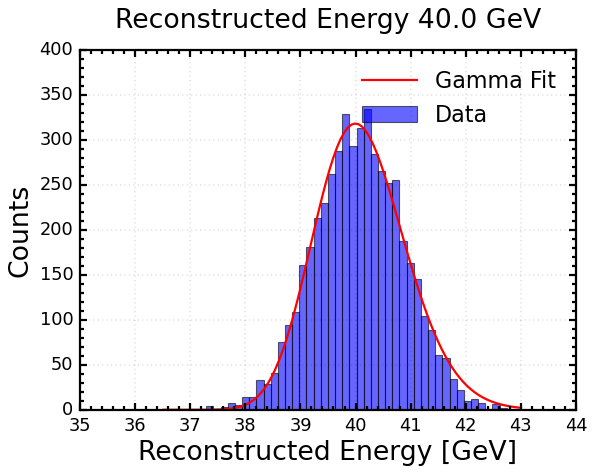

appending results for E = 40.0
Mean_Gamma: 40.12157237354053 Mean_Gamma_Error: 0.01906323011692391
Peak_Gamma: 39.99707208729032 Peak_Gamma_Error: 0.018871891854440173
Mean: 50.00730081446978, Peak: 50.12606156368281, RMS: 0.8996039374314185
Initial Gamma Fit Parameters: [np.float64(701.8320298993391), np.float64(3.6922830151374524), np.float64(46.68570847594098), np.float64(0.8996039374314185)]
Gamma Fit Bounds: lower [np.float64(7.018320298993391), np.float64(-0.6307716984862548), np.float64(3.668570847594098), np.float64(0.08996039374314185)], 
 upper [np.float64(4210.992179396035), np.float64(36.92283015137453), np.float64(80.02856271391147), np.float64(8.996039374314185)]
Gamma Fit Parameters: [6.97905723e+02 3.69228302e+01 4.46731752e+01 1.46510596e-01]
Gamma Fit Peak: 49.93625048641076 ± 0.022297192087844312, Mean: 50.08276108269621 ± 0.022546606654289907, Resolution: 0.0178279167469012 ± 0.0003105189904514732


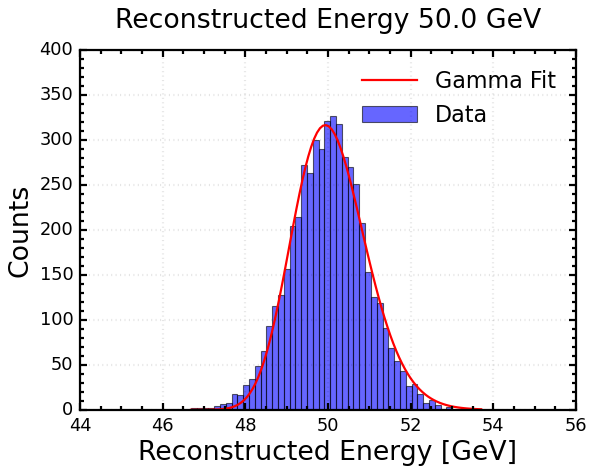

appending results for E = 50.0
Mean_Gamma: 50.08276108269621 Mean_Gamma_Error: 0.022546606654289907
Peak_Gamma: 49.93625048641076 Peak_Gamma_Error: 0.022297192087844312
Mean: 59.85171743901676, Peak: 59.94860380207234, RMS: 0.9970416079898465
Initial Gamma Fit Parameters: [np.float64(807.4407920029747), np.float64(4.3604936264175045), np.float64(55.504123862103974), np.float64(0.9970416079898465)]
Gamma Fit Bounds: lower [np.float64(8.074407920029747), np.float64(-0.5639506373582495), np.float64(4.550412386210398), np.float64(0.09970416079898466)], 
 upper [np.float64(4844.644752017848), np.float64(43.604936264175045), np.float64(93.25618579315596), np.float64(9.970416079898465)]
Gamma Fit Parameters: [8.05880831e+02 4.36049363e+01 5.33958065e+01 1.49971362e-01]
Gamma Fit Peak: 59.785326857232306 ± 0.024203727711241078, Mean: 59.93529821916556 ± 0.024439762481116505, Resolution: 0.01656462297830983 ± 0.00027780708931044


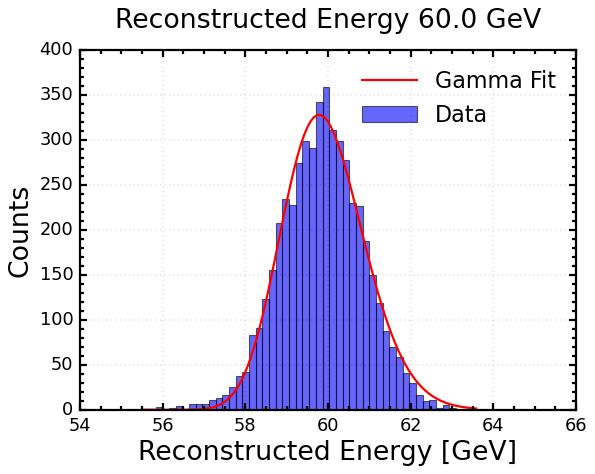

appending results for E = 60.0
Mean_Gamma: 59.93529821916556 Mean_Gamma_Error: 0.024439762481116505
Peak_Gamma: 59.785326857232306 Peak_Gamma_Error: 0.024203727711241078
Results saved to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer60_in120/Reco_Results/RecoE_MLP_Threshold0.1_WD1e-7_Fit.csv


In [18]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, best_val_loss, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["Energy"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
    print(f"Results saved to {CSV_name}")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_{MLP_Config}_Fit.csv")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit_Threshold{Threshold_i}.csv")
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Threshold{Threshold_i}_{MLP_Config}_Fit.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, best_val_loss, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")
with open(f'{DataPath_Validate}/Hist/MLP_Hists.pkl', 'wb') as f:
    pickle.dump(Reco_hist_mlp_all[0], f)